In [1]:
import pandas as pd
import numpy as np
import json
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso,Ridge
from visualization_utils import *
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import SplineTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
TRAIN_MODELS = False
results = []

In [3]:
import pandas as pd
from typing import Dict, Optional

# --- Mapping dictionaries (same categories we discussed) ---
brand_price_tier: Dict[str, str] = {
    "audi": "premium", "porsche": "luxury", "bmw": "luxury", "dodge": "mainstream",
    "dongfeng": "value", "ford": "mainstream", "honda": "mainstream", "hyundai": "mainstream",
    "land": "premium", "lexus": "premium", "maserati": "luxury", "mercedes-benz": "luxury",
    "skoda": "mainstream", "subaru": "mainstream", "toyota": "mainstream", "vw": "mainstream",
    "volvo": "premium", "alfa": "premium", "cupra": "upper_mid", "ds": "upper_mid",
    "haval": "value", "jeep": "upper_mid", "kia": "mainstream", "mazda": "mainstream",
    "mini": "premium", "peugeot": "mainstream", "mitsubishi": "mainstream", "nissan": "mainstream",
    "seat": "mainstream", "ssangyong": "value", "tesla": "premium", "acura": "premium",
    "alpina": "premium", "aston": "ultra_luxury", "bentley": "ultra_luxury", "byd": "value",
    "cadillac": "premium", "chevrolet": "mainstream", "chrysler": "mainstream", "citroen": "mainstream",
    "fiat": "mainstream", "foton": "value", "geely": "value", "genesis": "premium", "gmc": "premium",
    "great": "value", "jaguar": "premium", "infiniti": "premium", "lincoln": "premium",
    "lynkco": "upper_mid", "mg": "value", "opel": "mainstream", "renault": "mainstream",
    "smart": "niche", "voyah": "value", "dacia": "budget", "lada": "budget", "pontiac": "defunct",
    "suzuki": "mainstream", "daihatsu": "value", "gaz": "value", "isuzu": "value", "lancia": "niche",
    "mahindra": "value", "saab": "defunct", "daewoo": "defunct", "moskvich": "defunct",
    "trabant": "defunct", "triumph": "defunct", "uaz": "value", "wartburg": "defunct",
    "lamborghini": "ultra_luxury", "ferrari": "ultra_luxury", "maybach": "ultra_luxury",
    "baic": "value", "ineos": "niche", "morgan": "niche", "polestar": "premium", "tata": "value",
    "volga": "defunct", "abarth": "upper_mid", "hummer": "niche", "iveco": "value",
    "mclaren": "ultra_luxury", "rolls-royce": "ultra_luxury", "dkw": "defunct", "lotus": "niche",
    "secma": "niche", "други": "unknown", "baw": "value", "carbodies": "niche", "rover": "defunct",
    "talbot": "defunct", "daimler": "niche", "dr": "niche", "oldsmobile": "defunct", "buick": "premium",
    "gwm": "value", "swm": "value", "shuanghuan": "value", "changan": "value", "leapmotor": "value",
    "dfsk": "value", "чайка": "defunct", "austin": "defunct", "tempo": "defunct", "zaz": "defunct",
    "seres": "value", "maxus": "value", "microcar": "niche", "aixam": "niche", "chery": "value",
    "fisker": "niche", "jac": "value", "landwind": "value", "eagle": "defunct", "goupil": "niche",
    "brilliance": "value", "plymouth": "defunct", "asia": "unknown", "gonow": "value", "simca": "defunct",
    "wey": "upper_mid", "hongqi": "upper_mid"
}

brand_region: Dict[str, str] = {
    "audi": "europe", "porsche": "europe", "bmw": "europe", "dodge": "north_america", "dongfeng": "china",
    "ford": "north_america", "honda": "asia", "hyundai": "south_korea", "land": "uk", "lexus": "asia",
    "maserati": "europe", "mercedes-benz": "europe", "skoda": "europe", "subaru": "asia",
    "toyota": "asia", "vw": "europe", "volvo": "europe", "alfa": "europe", "cupra": "europe",
    "ds": "europe", "haval": "china", "jeep": "north_america", "kia": "south_korea", "mazda": "asia",
    "mini": "uk", "peugeot": "europe", "mitsubishi": "asia", "nissan": "asia", "seat": "europe",
    "ssangyong": "south_korea", "tesla": "north_america", "acura": "asia", "alpina": "europe",
    "aston": "uk", "bentley": "uk", "byd": "china", "cadillac": "north_america", "chevrolet": "north_america",
    "chrysler": "north_america", "citroen": "europe", "fiat": "europe", "foton": "china", "geely": "china",
    "genesis": "south_korea", "gmc": "north_america", "great": "china", "jaguar": "uk", "infiniti": "asia",
    "lincoln": "north_america", "lynkco": "china", "mg": "china", "opel": "europe", "renault": "europe",
    "smart": "europe", "voyah": "china", "dacia": "europe", "lada": "russia", "pontiac": "north_america",
    "suzuki": "asia", "daihatsu": "asia", "gaz": "russia", "isuzu": "asia", "lancia": "europe",
    "mahindra": "india", "saab": "europe", "daewoo": "asia", "moskvich": "russia", "trabant": "europe",
    "triumph": "uk", "uaz": "russia", "wartburg": "europe", "lamborghini": "europe", "ferrari": "europe",
    "maybach": "europe", "baic": "china", "ineos": "europe", "morgan": "uk", "polestar": "europe",
    "tata": "india", "volga": "russia", "abarth": "europe", "hummer": "north_america", "iveco": "europe",
    "mclaren": "uk", "rolls-royce": "uk", "dkw": "europe", "lotus": "uk", "secma": "europe", "други": "unknown",
    "baw": "china", "carbodies": "uk", "rover": "uk", "talbot": "europe", "daimler": "europe", "dr": "europe",
    "oldsmobile": "north_america", "buick": "north_america", "gwm": "china", "swm": "china", "shuanghuan": "china",
    "changan": "china", "leapmotor": "china", "dfsk": "china", "чайка": "russia", "austin": "uk", "tempo": "europe",
    "zaz": "europe", "seres": "china", "maxus": "china", "microcar": "europe", "aixam": "europe", "chery": "china",
    "fisker": "north_america", "jac": "china", "landwind": "china", "eagle": "north_america", "goupil": "europe",
    "brilliance": "china", "plymouth": "north_america", "asia": "unknown", "gonow": "china", "simca": "europe",
    "wey": "china", "hongqi": "china"
}

brand_ev_focus: Dict[str, str] = {
    "tesla": "ev_leader", "byd": "ev_leader", "polestar": "ev_active", "fisker": "ev_active",
    "nissan": "ev_present", "bmw": "ev_present", "audi": "ev_present", "mercedes-benz": "ev_present",
    "vw": "ev_present", "hyundai": "ev_present", "kia": "ev_present", "volvo": "ev_present",
    "genesis": "ev_present", "leapmotor": "ev_active", "seres": "ev_active", "voyah": "ev_active",
    "great": "ev_present", "gwm": "ev_present", "geely": "ev_present", "changan": "ev_present",
    "honda": "low_ev", "toyota": "low_ev", "ford": "ev_present", "chevrolet": "ev_present",
    "renault": "ev_present", "smart": "ev_present", "porsche": "ev_present", "mini": "ev_present",
    # fallback for others will be handled in the function
}

brand_orientation: Dict[str, str] = {
    "ferrari": "sport", "lamborghini": "sport", "mclaren": "sport", "lotus": "sport",
    "porsche": "performance", "alpina": "performance", "dodge": "performance", "abarth": "performance",
    "jeep": "utility_commercial", "foton": "utility_commercial", "gmc": "utility_commercial", "iveco": "utility_commercial",
    "ford": "family", "toyota": "family", "honda": "family", "nissan": "family", "renault": "family",
    "mini": "compact_city", "smart": "compact_city", "aixam": "compact_city", "microcar": "compact_city",
    "rolls-royce": "luxury_grand_tourer", "bentley": "luxury_grand_tourer", "maybach": "luxury_grand_tourer",
    # unspecified brands will get default "general"
}

brand_status: Dict[str, str] = {
    "saab": "defunct", "pontiac": "defunct", "oldsmobile": "defunct", "plymouth": "defunct",
    "daewoo": "defunct", "dkw": "defunct", "trabant": "defunct", "wartburg": "defunct",
    "moskvich": "defunct", "rover": "defunct", "talbot": "defunct", "simca": "defunct",
    "eagle": "defunct", "austin": "defunct", "tempo": "defunct", "volga": "defunct",
    "други": "unknown", "asia": "unknown"
}
def map_with_default(series: pd.Series, mapping: Dict[str, str], default: str,is_categorical=True) -> pd.Series:
    mapped_series = series.map(lambda x: mapping.get(x, default))
    if is_categorical:
        return mapped_series.astype("category")
    else:
        return mapped_series
# --- Function to apply mappings ---
def apply_brand_mappings(
    df: pd.DataFrame,
    brand_col: str = "Brand",
    price_tier_map: Optional[Dict[str, str]] = None,
    region_map: Optional[Dict[str, str]] = None,
    ev_map: Optional[Dict[str, str]] = None,
    orientation_map: Optional[Dict[str, str]] = None,
    status_map: Optional[Dict[str, str]] = None,
) -> pd.DataFrame:

    # choose maps, prefer overrides
    price_map = price_tier_map or brand_price_tier
    region_map = region_map or brand_region
    ev_map = ev_map or brand_ev_focus
    orient_map = orientation_map or brand_orientation
    status_map = status_map or brand_status


    brand_series = df[brand_col]

    df["brand_price_tier"] = map_with_default(brand_series, price_map, "unknown")
    df["brand_region"] = map_with_default(brand_series, region_map, "unknown")
    df["brand_ev_focus"] = map_with_default(brand_series, ev_map, "unknown")
    df["brand_orientation"] = map_with_default(brand_series, orient_map, "general")
    df["brand_status"] = map_with_default(brand_series, status_map, "active")

    return df

def handle_description(df):
    with open('keywords.json',encoding='utf-8') as f:
        keywords=json.load(f)
    bad_tokens = keywords['bad_words'] 
    good_tokens = keywords['good_words']
    bad_re = re.compile(r"\b(" + "|".join(map(re.escape, bad_tokens)) + r")\b", flags=re.I)
    good_re = re.compile(r"\b(" + "|".join(map(re.escape, good_tokens)) + r")\b", flags=re.I)

    def count_matches(text, pattern):
        if not isinstance(text, str):
            return 0
        return len(pattern.findall(text))

    # предполагаме df.description съдържа описанията

    df["bad_count"] = df["CarDescription"].apply(lambda t: count_matches(t, bad_re))
    df["good_count"] = df["CarDescription"].apply(lambda t: count_matches(t, good_re))


In [4]:
def remove_outliers_from_numeric_columns(df,columns,drop=False,std_multiplier=3):
    for column in columns:
        if drop:
            df = df.drop(df[df[column] >= df[column].mean() + std_multiplier * df[column].std()].index)
            df = df.drop(df[df[column] <= df[column].mean() - std_multiplier * df[column].std()].index)
        else:
            df[column].loc[df[column] >= df[column].mean() + std_multiplier * df[column].std()] = np.nan
            df[column].loc[df[column] <= df[column].mean() - std_multiplier * df[column].std()] = np.nan
    return df

def plot_importance(model,num_features=50):
    feature_importance_df = pd.DataFrame({
        'feature':model.feature_names_in_,
        'importance':model.feature_importances_
    }).sort_values('importance',ascending=False)
    plt.figure(figsize=(16, 16), dpi=80)
    plt.title('Feature Importance Most Important')
    plt.barh(feature_importance_df['feature'][:num_features],feature_importance_df['importance'][:num_features])
    plt.figure(figsize=(16, 16), dpi=80)
    plt.title('Feature Importance Least Important')
    plt.xlim(right=0.01)
    plt.barh(feature_importance_df['feature'][-num_features:],feature_importance_df['importance'][-num_features:])

    feature_importance_df['InitialColumn'] = feature_importance_df['feature'].str.split('_').str[0]
    aggregated = feature_importance_df.groupby('InitialColumn')['importance'].sum().sort_values(ascending=False)
    plt.figure(figsize=(16, 16), dpi=80)
    plt.title('Aggregated Feature Importance by Initial Column')
    plt.barh(aggregated.index[:num_features],aggregated.values[:num_features])
    return feature_importance_df,aggregated

def sumarize_small_values_in_column(df,column,threshold=0.01):
    value_counts = df[column].value_counts(normalize=True)
    small_values = value_counts[value_counts < threshold].index
    df[column] = df[column].replace(small_values, 'Other')
    return df, small_values

def impute_missing_numerical_values(df, numerical_columns):
    for col in numerical_columns:
        median = df[col].median()
        df[col] = df[col].fillna(median)
    return df

def get_split_data(df, target_column,seed=42):
    y=df[target_column]
    X=df.drop(columns=[target_column])
    return train_test_split(X, y, test_size=0.3, random_state=seed,shuffle=True)

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test,train_model=True,is_log_transform=False,display_graphs=True):
    if train_model:
        model.fit(X_train, y_train)
    results_train = model.predict(X_train)
    results_test = model.predict(X_test)
    if is_log_transform:
        results_train = np.exp(results_train)
        results_test = np.exp(results_test)
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
    train_r2 = r2_score(y_train,results_train)
    test_r2 = r2_score(y_test,results_test)
    train_rmse = root_mean_squared_error(y_train,results_train)
    test_rmse = root_mean_squared_error(y_test,results_test)
    train_mae = mean_absolute_error(y_train,results_train)
    test_mae = mean_absolute_error(y_test,results_test)
    train_score_adj_r2 = 1 - (1 - train_r2) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)
    test_score_adj_r2 = 1 - (1 - test_r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    print(f"Train R2: {round(train_r2, 4)}")
    print(f"Train Adjusted R2: {round(train_score_adj_r2, 4)}")
    print(f"Train RMSE: {round(train_rmse, 4)}")
    print(f"Train MAE: {round(train_mae,4)}")
    print(f"Test R2: {round(test_r2, 4)}")
    print(f"Test Adjusted R2: {round(test_score_adj_r2, 4)}")
    print(f"Test RMSE: {round(test_rmse, 4)}")
    print(f"Test MAE: {round(test_mae,4)}")
    if display_graphs:
        sns.regplot(x=y_test, y=results_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.grid(True)
        plt.show()
        residuals = y_test-results_test
        sns.histplot(residuals,bins=100)
    return train_r2,train_score_adj_r2,train_rmse,train_mae,test_r2,test_score_adj_r2,test_rmse,test_mae

def add_features(df):
    CURRENT_YEAR = 2025

    df['KmPerYear'] = df['KmDriven'] / (CURRENT_YEAR - df['Year']).replace(0, 1)
    df['HighKmPerYearFlag'] = (df['KmPerYear'] > df['KmPerYear'].quantile(0.95))
    df['LowKmPerYearFlag'] = (df['KmPerYear'] < df['KmPerYear'].quantile(0.05))
    df['Hoursepower_per_km'] = (df['Horsepower'] / df['KmDriven'].replace(0, 1))
    df['HP_per_cc'] = df['Horsepower'] / df['CubicCapacity'].replace(0, np.nan)
    df['Hoursepower_per_age'] = df['Horsepower'] /  (CURRENT_YEAR - df['Year']).replace(0, 1)

    df['bm_median_km'] = df.groupby(['Brand','Model'])['KmDriven'].transform('median')

    df['Km_vs_bm_median'] = df['KmDriven'] / df['bm_median_km'].replace(0, 1)



def read_data(file_path,drop_URL=True,drop_model_column=True,impute_missing=True,dummies_drop_first=True,handle_brand=False,model_plus_brand=False,add_new_features=False,drop_condition_col=True,keywords=False,drop_brand=False):
    df = pd.read_csv(file_path)
    # New feature: isElectric
    df['isElectric'] = ~df['WLTP_Range_km'].isna() | ~df['Battery_Capacity_kWh'].isna()
    # Impute missing values for electric car features with 0
    df['WLTP_Range_km'] = df['WLTP_Range_km'].fillna(0)
    df['Battery_Capacity_kWh'] = df['Battery_Capacity_kWh'].fillna(0)
    # Not used columns

    if not drop_model_column:
        model_processed=df['Model'].str.split(' ').str[1].str.lower().str.strip()
    df['Model'] = df['Model'].str.split(' ').str[1].str.lower().str.strip()


    if handle_brand:
        brand_processed = df['Brand'].str.lower().str.strip()
        df['Brand'] = brand_processed
        df=apply_brand_mappings(df)
        df,small_values_brand = sumarize_small_values_in_column(df,'Brand')

    if model_plus_brand:
        df['Brand_Model']=brand_processed+'_' + model_processed
        with open('model_price_tier.json') as f:
            model_price_mapping = json.load(f)
        df["model_price_tier"] = map_with_default(df["Brand_Model"], model_price_mapping, "unknown")
        with open('model_class_mapping.json') as f:
            model_class_mapping = json.load(f)
        df["model_class"] = map_with_default(df["Brand_Model"], model_class_mapping, "unknown")
        with open('model_price_score.json') as f:
            model_price_score_mapping = json.load(f)
        df["model_price_score"] = map_with_default(df["Brand_Model"], model_price_score_mapping, None).astype(float)
        df = df.drop(columns=['Brand_Model'])
    if add_new_features:
        add_features(df)
    df = df.drop(columns=['Month']) # Not useful for prediction
    if not drop_URL:
        url =df['URL']
    df = df.drop(columns=['URL']) # Not useful for prediction
    df = df.drop(columns=['Area']) # Very correlated with City and City has less missing values
    df = df.drop(columns=['Model']) # Too many unique values
    df = df.drop(columns=['Status']) # Artificial column created by mobile.bg
    if keywords:
        handle_description(df)
    if 'CarDescription' in df.columns:
        df =df.drop(columns=['CarDescription'])
    if drop_condition_col:
        df = df.drop(columns=['Condition']) # 97% empty
    if impute_missing:
        df = impute_missing_numerical_values(df, ['Year', 'Horsepower', 'CubicCapacity', 'KmDriven'])
    if drop_brand:
        df = df.drop(columns=['Brand'])
    print("Before onehot encoding",df.shape)
    df = pd.get_dummies(df,drop_first=dummies_drop_first)
    print("After onehot encoding",df.shape)
    if not drop_model_column:
        df['Model'] = model_processed

    if handle_brand:
        df['Brand'] = brand_processed
    if not drop_URL:
        df['URL']=url
    return df

def handle_model_column(X_train, X_test,column_name='Model'):
    counts = X_train[column_name].value_counts()
    counts = counts[counts >= 10]
    possible_values = set(counts.index.tolist())
    X_train.loc[~X_train[column_name].isin(possible_values), column_name] = 'Other'
    X_test.loc[~X_test[column_name].isin(possible_values), column_name] = 'Other'

    values = X_train.groupby(column_name)['CarPrice'].agg(['mean','std']).sort_values(by='mean', ascending=False)

    X_train['MeanPriceByModel'] = X_train[column_name].map(values['mean'])
    X_train['StdPriceByModel'] = X_train[column_name].map(values['std'])
    X_train['VariancePriceByModel'] = X_train[column_name].map(values['std']**2)
    X_test['MeanPriceByModel'] = X_test[column_name].map(values['mean'])
    X_test['StdPriceByModel'] = X_test[column_name].map(values['std'])
    X_test['VariancePriceByModel'] = X_test[column_name].map(values['std']**2)

# Neural Networks

In [5]:
import torch

In [6]:
BATCH_SIZE=32

In [7]:
device="cuda"

In [12]:
df = read_data('processed_data/preprocessed_car_data_full_brand_with_outliers.csv',drop_model_column=False,impute_missing=False,dummies_drop_first=False,handle_brand=True,model_plus_brand=True,add_new_features=True,drop_condition_col=True)


X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice',seed=42)

y_train = np.log(y_train)
y_test = np.log(y_test)
X_train['CarPrice'] = y_train
handle_model_column(X_train, X_test)
#handle_model_column(X_train, X_test,column_name='Brand')

X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
X_train = X_train.drop(columns=['Brand'])
X_test = X_test.drop(columns=['Brand'])

imputer = SimpleImputer()
imputer.fit(X_train)
X_train=imputer.transform(X_train)
X_test=imputer.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
print("Final training shape:",X_train.shape)
#final_model.fit(X_train, y_train,verbose=True,eval_set=[(X_test, y_test)])
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).to(dtype=torch.float32,device=device),torch.from_numpy(y_train.to_numpy()).to(dtype=torch.float32,device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).to(dtype=torch.float32,device=device),torch.from_numpy(y_test.to_numpy()).to(dtype=torch.float32,device=device))


Before onehot encoding (112477, 130)
After onehot encoding (112477, 262)
Final training shape: (78733, 264)


In [9]:
def test(test_dataloader,model,loss_fn,y_mean):
    cum_loss=0
    r_sq_up=0
    r_sq_down=0
    model.eval()

    with torch.no_grad():
        for X,y in test_dataloader:
            res = model(X).view(-1)
            loss = loss_fn(res,y)
            cum_loss+=loss

            r_sq_up+=((y-res)**2).sum()
            r_sq_down+=((y-y_mean)**2).sum()

    return (cum_loss/len(test_dataloader)).item(),(1-(r_sq_up/r_sq_down)).item()


def train(dataloader,model,loss_fn,optimizer,epochs,print_step=100,test_dataloader=None):
    all_losses=[]
    all_test_losses=[]
    test_r_sq=[]
    train_r_sq=[]
    if test_dataloader is not None:
        n_samples = 0
        sum_y = 0.0
        with torch.no_grad():
            for X, y in test_dataloader:
                y = y.to(device)
                y_flat = y.view(-1)
                sum_y += y_flat.sum().item()
                n_samples += y_flat.shape[0]

            if n_samples == 0:
                return float('nan'), float('nan')
            y_mean = sum_y / n_samples


    for i in range(epochs):
        model.train()

        current_losses=[]
        iteration=0
        r_sq_up=0
        r_sq_down=0
        for X,y in dataloader:
            model.eval()
            res = model(X).view(-1)
            optimizer.zero_grad()

            loss = loss_fn(res,y)
            current_losses.append(loss.item())
            loss.backward()
            optimizer.step()

            r_sq_up+=((y-res)**2).sum()
            r_sq_down+=((y-y_mean)**2).sum()
            iteration+=1
            if iteration%print_step==0:
                print(f"Epoch:{i} Iteration:{iteration} Loss:{loss.item()}")

        if test_dataloader is not None:
            test_loss,r_sq = test(test_dataloader,model,loss_fn,y_mean)
            all_test_losses.append(test_loss)
            test_r_sq.append(r_sq)
            r_sq_train=(1-(r_sq_up/r_sq_down)).item()
            train_r_sq.append(r_sq_train)
            print(f"Epoch:{i} Test Loss:{test_loss}, Train R^2:{r_sq_train}, Test R^2:{r_sq}")

        all_losses.append(current_losses)

    return all_losses,all_test_losses,test_r_sq,train_r_sq


Epoch:0 Iteration:100 Loss:0.6820831298828125
Epoch:0 Iteration:200 Loss:0.3320488929748535
Epoch:0 Iteration:300 Loss:0.4494172930717468
Epoch:0 Iteration:400 Loss:0.1836060732603073
Epoch:0 Iteration:500 Loss:0.43586021661758423
Epoch:0 Iteration:600 Loss:0.1620320975780487
Epoch:0 Iteration:700 Loss:0.18828754127025604
Epoch:0 Iteration:800 Loss:0.23635753989219666
Epoch:0 Iteration:900 Loss:0.13264375925064087
Epoch:0 Iteration:1000 Loss:0.2013109177350998
Epoch:0 Iteration:1100 Loss:0.1883859932422638
Epoch:0 Iteration:1200 Loss:0.19700314104557037
Epoch:0 Iteration:1300 Loss:0.11958666890859604
Epoch:0 Iteration:1400 Loss:0.29116639494895935
Epoch:0 Iteration:1500 Loss:0.08350849151611328
Epoch:0 Iteration:1600 Loss:0.06144416332244873
Epoch:0 Iteration:1700 Loss:0.1525992900133133
Epoch:0 Iteration:1800 Loss:0.11696886271238327
Epoch:0 Iteration:1900 Loss:0.5325376391410828
Epoch:0 Iteration:2000 Loss:0.10979282110929489
Epoch:0 Iteration:2100 Loss:0.1965419352054596
Epoch:0 Ite

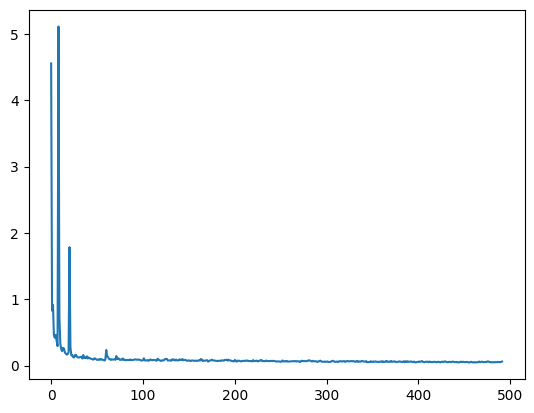

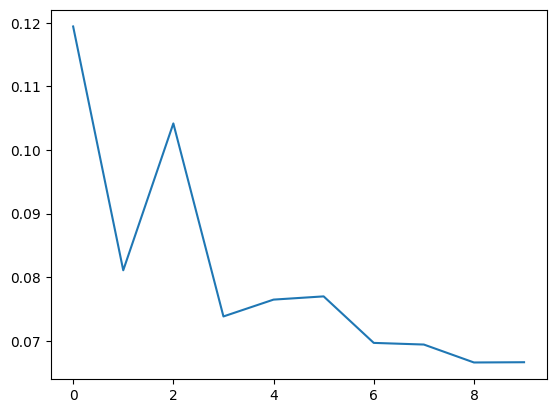

In [14]:
BATCH_SIZE=32
learning_rate=0.001
hidden_size=64
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)
network=torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1],hidden_size*2),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.BatchNorm1d(hidden_size*2),
    torch.nn.Linear(hidden_size*2,hidden_size*4),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.BatchNorm1d(hidden_size*4),
    torch.nn.Linear(hidden_size*4,hidden_size*8),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(hidden_size*8),
    torch.nn.Linear(hidden_size*8,1),
).to(device)
optimizer = torch.optim.Adam(network.parameters(),lr=learning_rate)
loss = torch.nn.functional.mse_loss
train_res,test_res,test_r_sq,train_r_sq = train(train_dataloader,network,loss,optimizer,epochs=10,test_dataloader=test_dataloader)

result = torch.tensor(train_res).flatten()
elements = result.shape[0]
window_size = 50
to_plot=result[-window_size*(elements//window_size):].view(-1,window_size).mean(-1)
plt.plot(to_plot)
plt.show()
plt.plot(test_res)

In [11]:
from sklearn.preprocessing import LabelEncoder

In [30]:
brand_column='Brand'
df = read_data('processed_data/preprocessed_car_data_full_brand_with_outliers.csv',drop_model_column=False,impute_missing=False,dummies_drop_first=True,handle_brand=True,model_plus_brand=True,add_new_features=False,drop_condition_col=True,drop_brand=True)
brand = pd.read_csv('processed_data/preprocessed_car_data_full_brand_with_outliers.csv')[brand_column]
label_encoder = LabelEncoder()
brand=label_encoder.fit_transform(brand)
df[brand_column]=brand
X_train, X_test, y_train, y_test = get_split_data(df, 'CarPrice',seed=42)

train_brand = X_train[brand_column]


y_train = np.log(y_train)
y_test = np.log(y_test)
X_train['CarPrice'] = y_train
handle_model_column(X_train, X_test)
#handle_model_column(X_train, X_test,column_name='Brand')

X_train = X_train.drop(columns=['CarPrice'])
X_train = X_train.drop(columns=['Model'])
X_test = X_test.drop(columns=['Model'])
X_train = X_train.drop(columns=['Brand'])
X_test = X_test.drop(columns=['Brand'])

imputer = SimpleImputer()
imputer.fit(X_train)
X_train=imputer.transform(X_train)
X_test=imputer.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
print("Final training shape:",X_train.shape)
#final_model.fit(X_train, y_train,verbose=True,eval_set=[(X_test, y_test)])
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).to(dtype=torch.float32,device=device),torch.from_numpy(y_train.to_numpy()).to(dtype=torch.float32,device=device),torch.from_numpy(train_brand.to_numpy()).to(dtype=torch.int32,device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).to(dtype=torch.float32,device=device),torch.from_numpy(y_test.to_numpy()).to(dtype=torch.float32,device=device),torch.from_numpy(test_brand.to_numpy()).to(dtype=torch.int32,device=device))


Before onehot encoding (112477, 121)
After onehot encoding (112477, 216)
Final training shape: (78733, 218)


In [20]:
def test(test_dataloader,model,loss_fn,y_mean):
    cum_loss=0
    r_sq_up=0
    r_sq_down=0
    model.eval()

    with torch.no_grad():
        for X,y,brand in test_dataloader:
            res = model(X,brand).view(-1)
            loss = loss_fn(res,y)
            cum_loss+=loss

            r_sq_up+=((y-res)**2).sum()
            r_sq_down+=((y-y_mean)**2).sum()

    return (cum_loss/len(test_dataloader)).item(),(1-(r_sq_up/r_sq_down)).item()


def train(dataloader,model,loss_fn,optimizer,epochs,print_step=100,test_dataloader=None):
    all_losses=[]
    all_test_losses=[]
    test_r_sq=[]
    train_r_sq=[]
    if test_dataloader is not None:
        n_samples = 0
        sum_y = 0.0
        with torch.no_grad():
            for X, y,brand in test_dataloader:
                y = y.to(device)
                y_flat = y.view(-1)
                sum_y += y_flat.sum().item()
                n_samples += y_flat.shape[0]

            if n_samples == 0:
                return float('nan'), float('nan')
            y_mean = sum_y / n_samples


    for i in range(epochs):
        model.train()

        current_losses=[]
        iteration=0
        r_sq_up=0
        r_sq_down=0
        for X,y,brand in dataloader:
            model.eval()
            res = model(X,brand).view(-1)
            optimizer.zero_grad()

            loss = loss_fn(res,y)
            current_losses.append(loss.item())
            loss.backward()
            optimizer.step()

            r_sq_up+=((y-res)**2).sum()
            r_sq_down+=((y-y_mean)**2).sum()
            iteration+=1
            if iteration%print_step==0:
                print(f"Epoch:{i} Iteration:{iteration} Loss:{loss.item()}")

        if test_dataloader is not None:
            test_loss,r_sq = test(test_dataloader,model,loss_fn,y_mean)
            all_test_losses.append(test_loss)
            test_r_sq.append(r_sq)
            r_sq_train=(1-(r_sq_up/r_sq_down)).item()
            train_r_sq.append(r_sq_train)
            print(f"Epoch:{i} Test Loss:{test_loss}, Train R^2:{r_sq_train}, Test R^2:{r_sq}")

        all_losses.append(current_losses)

    return all_losses,all_test_losses,test_r_sq,train_r_sq


In [ ]:
class Model(torch.nn.Module):

    def __init__(self,input_shape,brand_dim,embed_dim,hidden_size):
        super().__init__()
        self.embed = torch.nn.Embedding(brand_dim,embed_dim)
        self.network=torch.nn.Sequential(
            torch.nn.Linear(embed_dim+input_shape,hidden_size*2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.BatchNorm1d(hidden_size*2),
            torch.nn.Linear(hidden_size*2,hidden_size*4),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.BatchNorm1d(hidden_size*4),
            torch.nn.Linear(hidden_size*4,hidden_size*8),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_size*8),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(hidden_size*8,1),
        )

    def forward(self,X,brand):
        brand_embed=self.embed(brand)
        return self.network(torch.concat((X,brand_embed),dim=1))


Epoch:0 Iteration:100 Loss:0.47796517610549927
Epoch:0 Iteration:200 Loss:0.38129469752311707
Epoch:0 Iteration:300 Loss:0.1558576226234436
Epoch:0 Iteration:400 Loss:0.18258671462535858
Epoch:0 Iteration:500 Loss:0.13677111268043518
Epoch:0 Iteration:600 Loss:0.2153133749961853
Epoch:0 Iteration:700 Loss:0.23336416482925415
Epoch:0 Iteration:800 Loss:0.2695659399032593
Epoch:0 Iteration:900 Loss:0.219628244638443
Epoch:0 Iteration:1000 Loss:0.16710378229618073
Epoch:0 Iteration:1100 Loss:0.23915132880210876
Epoch:0 Iteration:1200 Loss:0.10365127772092819
Epoch:0 Iteration:1300 Loss:0.11297035962343216
Epoch:0 Iteration:1400 Loss:0.223992720246315
Epoch:0 Iteration:1500 Loss:0.10056393593549728
Epoch:0 Iteration:1600 Loss:0.1247183308005333
Epoch:0 Iteration:1700 Loss:0.1510932743549347
Epoch:0 Iteration:1800 Loss:0.18114829063415527
Epoch:0 Iteration:1900 Loss:0.11786503344774246
Epoch:0 Iteration:2000 Loss:0.14040938019752502
Epoch:0 Iteration:2100 Loss:0.18400511145591736
Epoch:0 It

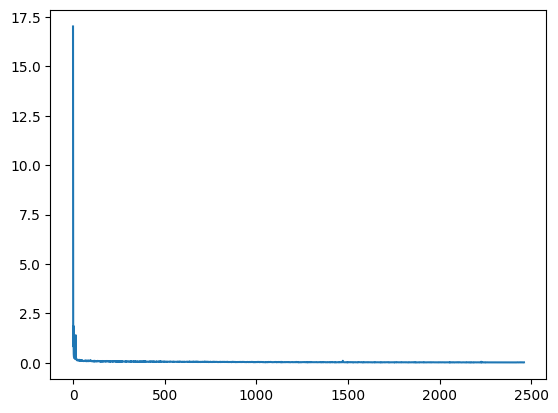

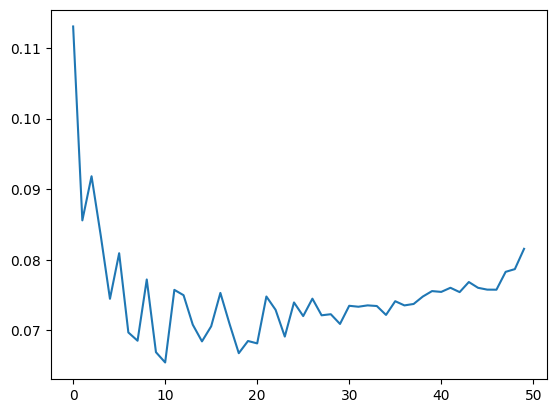

In [31]:
BATCH_SIZE=32
learning_rate=0.001
hidden_size=64
embed_dim=64
brands_dim=brand.max()+1

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)
network=Model(X_train.shape[1],brands_dim,embed_dim,hidden_size).to(device)
optimizer = torch.optim.Adam(network.parameters(),lr=learning_rate)
loss = torch.nn.functional.mse_loss
train_res,test_res,test_r_sq,train_r_sq = train(train_dataloader,network,loss,optimizer,epochs=50,test_dataloader=test_dataloader)

result = torch.tensor(train_res).flatten()
elements = result.shape[0]
window_size = 50
to_plot=result[-window_size*(elements//window_size):].view(-1,window_size).mean(-1)
plt.plot(to_plot)
plt.show()
plt.plot(test_res)